In [1]:
# Kaggle
# https://www.kaggle.com/docstein/brics-world-bank-indicators
# https://www.kaggle.com/worldbank/world-development-indicators?select=Indicators.csv

# Resources
# https://datahelpdesk.worldbank.org/knowledgebase/articles/906531-methodologies

# Group members and their contributions

The team members are:

- Maalidefaa Moses Tantuoyir: Data Preprocessing, PCA, Heirarchical Clustering (Features), SVM, Report.
- Nidaa Raji: Data Preprocessing, ARIMA, Report.
- Yoseif Abraham Hailemariam: Data preprocessing, Random Forest Regression and Report.
- Kobina Andam Quansah: -  Data preprocessing, Feature correlation heatmap, Country clustering, VAR, Report
- Vitalijus Gorbunovas: - Data Preprocessing, ARIMA, Report

# Abstract

The purpose of this project was to preprocess, cluster and predict World Bank data gathered since 1960 to 2015. The data consists of global developmental indicators like, birth rate, death rate, adult dependency ratio, urban population growth etc. for individual countries. 

We narrowed down our analysis of these indicators and countries by using the most recent national accounts methodology (2008), which gave us a total of 44 countries and 215 indicators. To understand and extract the most important indicators for further analysis, we used principal component analysis. This gave us important indicators such us 'Urban Population Growth', 'Adolescent Fertility Rate' among others which best described our data over a period of 25 years. We further clustered the countries using based on their Dynamic Time Warping distance. To achieve this, we employed Hierarchical clustering, K-means paired with multidimensional scaling. We got clusters of countries mostly based on similarity of developmental levels and economic regions. For example, Scandinavian countries were in the same clusters, so were South American countries.

We further used different time series methods to predict one of the important indicators (Population ages 15-64 (% of total population)) determined through PCA and using MAPE and MSE to evaluate the performance of these models. In our analysis, Random Forest performed the best with a MAPE OF 0.68, followed by Vector Autoregression (VAR), Support Vector Regressor (SVR) and ARIMA forecasting.

# Introduction

This is a final project for the course Introduction to Data Science. Our main task is to explore the data obtained from the World Bank and obtain some important features among the countries, cluster the countries according to features and make time series predictions using an indicator of interest (after feature selection).
The World Development Indicators from the World Bank contain over a thousand annual indicators of economic development from hundreds of countries around the world. For example, this data includes the life expectancy at birth from many countries around the world. It is made available on Kaggle by the World Bank.

The dataset has different 4 csv files which contain countries, indicators, series and country notes.  Various countries use different systems of national accounts methodology. We filtered our final data based on the 2008 system of national accounts methodology. Countries based on this methodology do have more data recorded than those that used earlier methodologies (1968 and 1993). The final data contained 44 countries in total with 215 features. 

We explored various imputation methods. They include simple imputation, linear interpolation, forward and backward fill etc. We settled on linear interpolation and simple imputation (with mean) based on recommendation from our mentor.
To understand our data better and extract the best features, we used principal component analysis and correlation plots. Various clustering methods were exploited to help understand the data better. The clustering methods used included: hierarchical, K-means paired with multidimensional scaling and K-medoids.  Dynamic Time warping was also employed.

Time series analysis/predictions are then done using as country of interest (USA) and one of the most important features we determined using the PCA. The time series analysis performed include: Vector Auto Regression, Support Vector Regressor (SVR), Random forest Regression, ARIMA forecasting.

To evaluate our models, we used the mean average percentage error (MAPE) method and mean squared error method (MSE).


# Setup and configuration

In [2]:
!pip install dtaidistance
!pip install pyclustering

import os
import zipfile
import math
import warnings
import numpy as np
import pandas as pd
import pyclustering
import dtaidistance
import seaborn as sns 
from fastdtw import fastdtw
from sklearn import manifold 
from matplotlib import pyplot
import matplotlib.pyplot as plt
import statsmodels.tsa.vector_ar
#from statsmodels.tsa.api import VAR
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import AgglomerativeClustering
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import euclidean, squareform
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pyclustering.cluster import cluster_visualizer_multidim
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from scipy.stats import normaltest
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

%matplotlib inline

In [3]:
# Define the environment where notebook is run.
# Use "local" when running on local machine. Extract data files to the "data" folder.
# Use "colab" when running on Google Colab. Files will be automatically downloaded
# from kaggle (given that kaggle username and key are provided).

environment = 'local'

if environment == 'local':
    # prepare dataframes
    series_path = "data/Series.csv"
    country_path = "data/Country.csv"
    indicators_path = "data/Indicators.csv"
    country_notes_path = "data/CountryNotes.csv"
elif environment == 'colab':
    # imports
    from google.colab import drive
    drive.mount('/content/drive')
    # download from kaggle
    os.environ['KAGGLE_USERNAME'] = "cubicsrube" # username from the json file
    os.environ['KAGGLE_KEY'] = "6e2367734120e39c492cbf125549e6ca" # key from the json file
    !kaggle datasets download -d worldbank/world-development-indicators # api copied from kaggle
    # unzip
    with zipfile.ZipFile('/content/world-development-indicators.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    # prepare dataframes
    series_path = "/content/data/Series.csv"
    country_path = "/content/data/Country.csv"
    indicators_path = "/content/data/Indicators.csv"
    country_notes_path = "/content/data/CountryNotes.csv"
else:
    raise Exception('Set "environment" variable. Current value is "{}".'.format(environment))

series_df = pd.read_csv(series_path, sep=",")
country_df = pd.read_csv(country_path, sep=",")
indicators_df = pd.read_csv(indicators_path, sep=",")
country_notes_df = pd.read_csv(country_notes_path, sep=",")

FILER DATA FROM COUNTRIES THAT ONLY USED THE 2008 SYSTEM OF NATIONAL ACCOUNTS METHODOLOGY

We chose to use the 2008 system only, as it is the most recent and the data s is better if it is gathered in a similar manner.

In [4]:
# Country filters ['SystemOfNationalAccounts']
# - Country uses the 1968 System of National Accounts methodology.
# - Country uses the 1993 System of National Accounts methodology.
# - Country uses the 2008 System of National Accounts methodology.
countries = country_df[country_df['SystemOfNationalAccounts']=='Country uses the 2008 System of National Accounts methodology.'].reset_index()
 
country_codes = list(countries['CountryCode'])

### Data preprocessing

The input data was inconsistent. Certain countries did not have data for certain indicators. In order to ensure consistency in the data, we needed to transform the data from the original format to a 2D dataframe with a primary index and secondary index, which are country name and year respectively. Indicators are located in columns. As a result of the transformation, NA values would be placed in the cells which were not measured for a particular country for a particular year. Interpolation and imputation methods would then be used to fill these NA columns. 

A function was then created with two thresholds. One threshold would be used to disqualify countries with too many NA cells. The second threshold would be used to disqualify indicators with too many NA cells.

Import DataFrames

In [5]:
indicators_countries =indicators_df
col_filtered = indicators_countries[["IndicatorCode","CountryCode","Year","Value"]]
years = list(col_filtered["Year"].unique())
ind_codes = list(col_filtered["IndicatorCode"].unique())
full_data = list(indicators_countries["IndicatorCode"].unique())
len(ind_codes) #determine the total number of indicators

1344

Create Function to fill all countries with all possible indicators. NA values 
will be filled in cells where indicator is not measured for the particular country that year.

In [6]:
def get_tbl_full_year(country_code,year):
  """
  Returns table of dataframes. Each dataframe corresponds to one of the remaining
  countries to be studied
  """
  #determine the unique indicators which exist for a particular country
  df2 = col_filtered[col_filtered["CountryCode"] == country_code]

  #get all indicators for a particular year
  ind_dicts = list(map(lambda x: get_ind_dict(df2,x), year))

  #create dictionary for all indicators for all years
  ind_dicts = list(map(lambda x: create_dict(x), ind_dicts))
  return (ind_dicts)

def get_ind_dict(df2,year):
  """
  Returns all the indicators measured for a particular year
  """
  #Filter the particular year under consideration
  df3 = df2[df2["Year"] == year][["IndicatorCode","Value"]]
  df3.set_index("IndicatorCode",inplace=True)
  df3 =  df3.transpose()

  #Create dictionary for all indicators for all years
  ind_dict = dict(df3)
  ind_dict = create_dict(ind_dict)
  return (ind_dict)
  
def create_dict(ind_dict): 
  """
  Returns a dictionary mapping indicators to their readings for that year
  """

  #iterate over all keys and add indicator when indicator is present in 
  #country list
  for key in ind_dict:
    try:
      ind_dict[key] = ind_dict[key][0]
    except (IndexError, TypeError):
      pass

  #return all keys from dictionary of indicators which are not present in the 
  #country under consideration
  absent_bool = list(map(lambda x: x not in ind_dict, full_data))
  absent_array = np.array(full_data)[np.array(absent_bool)]
  absent_dict = {}

  #update all absent values with NaN
  for i in range(len(absent_array)):
    absent_dict.update({absent_array[i]:np.nan})
  ind_dict.update(absent_dict)
  return (ind_dict)

In [7]:
def fn(index, from_year, to_year):
  """
  Returns a dataframe
  """
  
  n_years = to_year - from_year
  a = get_tbl_full_year(country_codes[index], list(range(from_year, to_year)))
  a = pd.DataFrame(a)
  a.index = [np.tile(country_codes[index], to_year - from_year), np.arange(from_year, to_year, 1)]
  return a

# processed_attributes = pd.DataFrame(dict()) #fn(0, 2008, 2016)
def create_df(max_na, threshold, from_year, to_year):
  """
  Returns a dataframe of the complete dataset containing all countries with all
  their measured and unmeasured indicators from "from_year" to "to_year" using
  "max_na" as the country relegation threshold and "threshold" for the indicator
  relegator.
  """  
  processed_attributes = None
  n_years = to_year - from_year

  #Iterate over the list of country codes and reject countries with more than 
  #max_na NaN values in total.
  for i in range(0, len(country_codes)):
    temp = fn(i, from_year, to_year)
    perc = 1 - temp.applymap(lambda x: pd.isna(x)).sum().sum() / np.prod(temp.shape)
    if perc > max_na:
      #If NaN values are less than min_na fraction of the data, create dataframe
      #including unmeasured values and append to dataframe of full data.
      print(f"Adding {country_codes[i]} {perc}")
      if processed_attributes is None:
        processed_attributes = temp
      else:
        processed_attributes = pd.concat([processed_attributes, temp], axis=0)
    else:
      #Display the progression.
      print(f"Skipping {country_codes[i]} {perc}")

  #Drop indicators based on the country relegator threshold.
  processed_attributes.dropna(thresh=(threshold*len(processed_attributes.index)), axis=1, inplace=True)
  return (processed_attributes, n_years)

In [8]:
processed_attributes , n_years= create_df(0.3, 0.99, 1990,2015)

Adding ARG 0.4833035714285714
Adding AUS 0.4632440476190476
Adding AUT 0.4811607142857143
Adding BEL 0.463125
Adding CAN 0.4529761904761904
Adding CZE 0.49872023809523813
Adding DNK 0.4911011904761905
Adding ECU 0.6455654761904762
Adding EST 0.45895833333333336
Adding FIN 0.4933630952380952
Adding FRA 0.48684523809523805
Adding DEU 0.4795238095238096
Adding GRC 0.47627976190476196
Adding HKG 0.38592261904761904
Adding HUN 0.5111011904761904
Adding ISL 0.4392559523809524
Adding IND 0.6361309523809524
Adding IRL 0.47901785714285716
Adding ISR 0.43875
Adding ITA 0.4899404761904762
Adding KOR 0.5043154761904762
Adding LVA 0.45116071428571425
Adding LTU 0.4419047619047619
Adding LUX 0.41770833333333335
Adding MEX 0.6895238095238095
Adding NLD 0.4805952380952381
Adding NZL 0.43675595238095233
Adding NGA 0.5913690476190476
Adding NOR 0.47413690476190473
Adding POL 0.4951488095238096
Adding PRT 0.4770833333333333
Adding RWA 0.5667559523809524
Adding SGP 0.4202678571428572
Adding SVK 0.46220238

OBTAIN SUMMARY OF RESULTANT DATAFRAME

In [9]:
processed_attributes

SP.ADO.TFRT  SP.POP.DPND  SP.POP.DPND.OL  SP.POP.DPND.YG  \
ARG 1990      73.2812    65.745925       15.005772       50.740153   
    1991      73.2416    65.644754       15.173254       50.471500   
    1992      73.2020    65.153818       15.309149       49.844669   
    1993      72.5218    64.427990       15.417134       49.010855   
    1994      71.8416    63.701944       15.502496       48.199448   
...               ...          ...             ...             ...   
ZMB 2010     110.8044    98.148325        5.772203       92.376122   
    2011     107.0682    97.854237        5.774172       92.080065   
    2012     103.3320    97.385802        5.768295       91.617507   
    2013      98.1738    96.791310        5.752790       91.038521   
    2014      93.0156    96.122165        5.724731       90.397434   

          PA.NUS.ATLS  IT.MLT.MAIN  IT.MLT.MAIN.P2  SH.TBS.INCD  \
ARG 1990      0.48759    3026732.0        9.277375         43.0   
    1991      0.95350    3131235.0        9.467019         44.0   
    1992      0.99060    3594533.0       10.723290         44.0   
    1993      0.99900    3982435.0       11.726168         44.0   
    1994      1.00000    4986887.0       14.497041         44.0   
...               ...          ...             ...          ...   
ZMB 2010      4.79710     118388.0        0.895726        495.0   
    2011      4.86070      85727.0        0.628783        475.0   
    2012      5.14730      82542.0        0.586440        456.0   
    2013      5.39590     115762.0        0.796237        437.0   
    2014      6.15280     114420.0        0.761733        406.0   

          SL.TLF.ACTI.1524.FE.ZS  SL.TLF.ACTI.1524.MA.ZS  ...  \
ARG 1990               43.700001               68.199997  ...   
    1991               42.400002               66.599998  ...   
    1992               41.299999               65.000000  ...   
    1993               40.900002               63.900002  ...   
    1994               40.500000               62.900002  ...   
...                          ...                     ...  ...   
ZMB 2010               64.800003               70.400002  ...   
    2011               64.599998               70.199997  ...   
    2012               64.400002               70.000000  ...   
    2013               64.099998               69.699997  ...   
    2014               63.900002               69.599998  ...   

          SP.POP.TOTL.FE.ZS  SP.POP.TOTL  SL.TLF.CACT.FM.ZS  SP.RUR.TOTL  \
ARG 1990          50.970576   32729740.0          52.767055    4260103.0   
    1991          50.983912   33193920.0          52.393271    4206334.0   
    1992          50.992450   33655149.0          52.213538    4192758.0   
    1993          50.998361   34110912.0          52.748689    4177905.0   
    1994          51.004534   34558114.0          53.088045    4160797.0   
...                     ...          ...                ...          ...   
ZMB 2010          50.114759   13917439.0          85.331783    8527911.0   
    2011          50.102402   14343526.0          85.314679    8727605.0   
    2012          50.091607   14786581.0          85.414235    8933017.0   
    2013          50.083051   15246086.0          85.397196    9143535.0   
    2014          50.077554   15721343.0          85.280375    9358601.0   

          SP.RUR.TOTL.ZS  SE.PRM.DURS  SE.SEC.DURS  SP.URB.TOTL  \
ARG 1990          13.016          7.0          5.0   28469637.0   
    1991          12.672          7.0          5.0   28987586.0   
    1992          12.458          7.0          5.0   29462391.0   
    1993          12.248          7.0          5.0   29933007.0   
    1994          12.040          7.0          5.0   30397317.0   
...                  ...          ...          ...          ...   
ZMB 2010          61.275          7.0          5.0    5389528.0   
    2011          60.847          7.0          5.0    5615921.0   
    2012          60.413          7.0          5.0    5853564.0   


In [10]:
total_values = processed_attributes.count().sum()
total_values_na = processed_attributes.applymap(lambda x: pd.isna(x)).sum().sum()
print(f"Total: {total_values + total_values_na}, Values: {total_values}, NA: {total_values_na}")

Total: 40700, Values: 40680, NA: 20


DETERMINE NUMBER OF COUNTRIES REMAINING

In [11]:
#processed_attributes.to_csv('/content/data.csv')
filtered_series = series_df[series_df['SeriesCode'].isin(processed_attributes.columns)]
#filtered_series.to_csv('/content/data.csv')
print(f"There are {len(processed_attributes.index)/n_years} countries left")

There are 44.0 countries left


GET LIST OF ALL COUNTRIES REMAINING FOR LATER USE

In [12]:
def get_country_list(processed_attributes):
  """
  Returns the list of remaining countries from the processed arguments dataframe.
  """
  country_set = set((processed_attributes.index).map(lambda x: x[0]))
  country_list = list(country_set)
  country_list.sort()
  return country_list
country_list = get_country_list(processed_attributes)

PRINT REMAINING COUNTRIES

In [13]:
print(country_list)

['ARG', 'AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CZE', 'DEU', 'DNK', 'ECU', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HKG', 'HUN', 'IND', 'IRL', 'ISL', 'ISR', 'ITA', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NGA', 'NLD', 'NOR', 'NZL', 'POL', 'PRT', 'RWA', 'SGP', 'SVK', 'SVN', 'SWE', 'TZA', 'UGA', 'USA', 'ZAF', 'ZMB']


INTERPOLATE AND IMPUTE WHERE INTERPOLATION DID NOT WORK

In [14]:
def impute(processed_attributes,index):
  """
  Performs interpolation, followed by simple imputation to fill NaN cells and 
  returns dataframe of imputed data for a single country from the given dataframe
  using the positional indexer.
  """
  df_cum = processed_attributes[(processed_attributes.index).map(lambda x: x[0] == country_list[index])]
  nan_cols = [i for i in df_cum.columns if df_cum[i].isnull().all()]
  for colname in nan_cols:
    df_cum[[colname]] = 0;
  imputed_data = df_cum.apply(lambda x:x.interpolate(method='linear'))
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy = True)
  imputed_data = pd.DataFrame(imp_mean.fit_transform(imputed_data))
  imputed_data.columns = df_cum.columns
  #data1 = data1.fillna(method='ffill')
  return imputed_data #pd.DataFrame(imputed_data, columns = df_cum.columns)

In [15]:
def impute_a(processed_attributes, rng):
  """
  Iterates over the imputation method above(impute) for each country
  """
  return list(map(lambda x: impute(processed_attributes, x),rng))
imputed_array = impute_a(processed_attributes, range(0,len(country_list)))

PERFORM INTERPOLATION AND IMPUTATION

In [16]:
data_final = pd.concat(imputed_array)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_final)
data_scaled = pd.DataFrame(data_scaled, columns=data_final.columns)
inds = data_scaled.columns

In [17]:
def corrmat(abs=False):
  """
  Plots a heatmap of the pearson correlation coefficient or the absolute person
  correlation coefficient.
  """
  f = plt.figure(figsize=(30, 15))
  if abs == True:
    plt.matshow(np.abs(data_scaled.corr()), fignum=f.number)
  else:
    plt.matshow(data_scaled.corr(), fignum=f.number)
  plt.xticks(range(data_scaled.shape[1]), inds, fontsize=10, rotation=90)
  plt.yticks(range(data_scaled.shape[1]), inds, fontsize=10)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=10)

VISUALIZE CORRELATION HEATMAPS

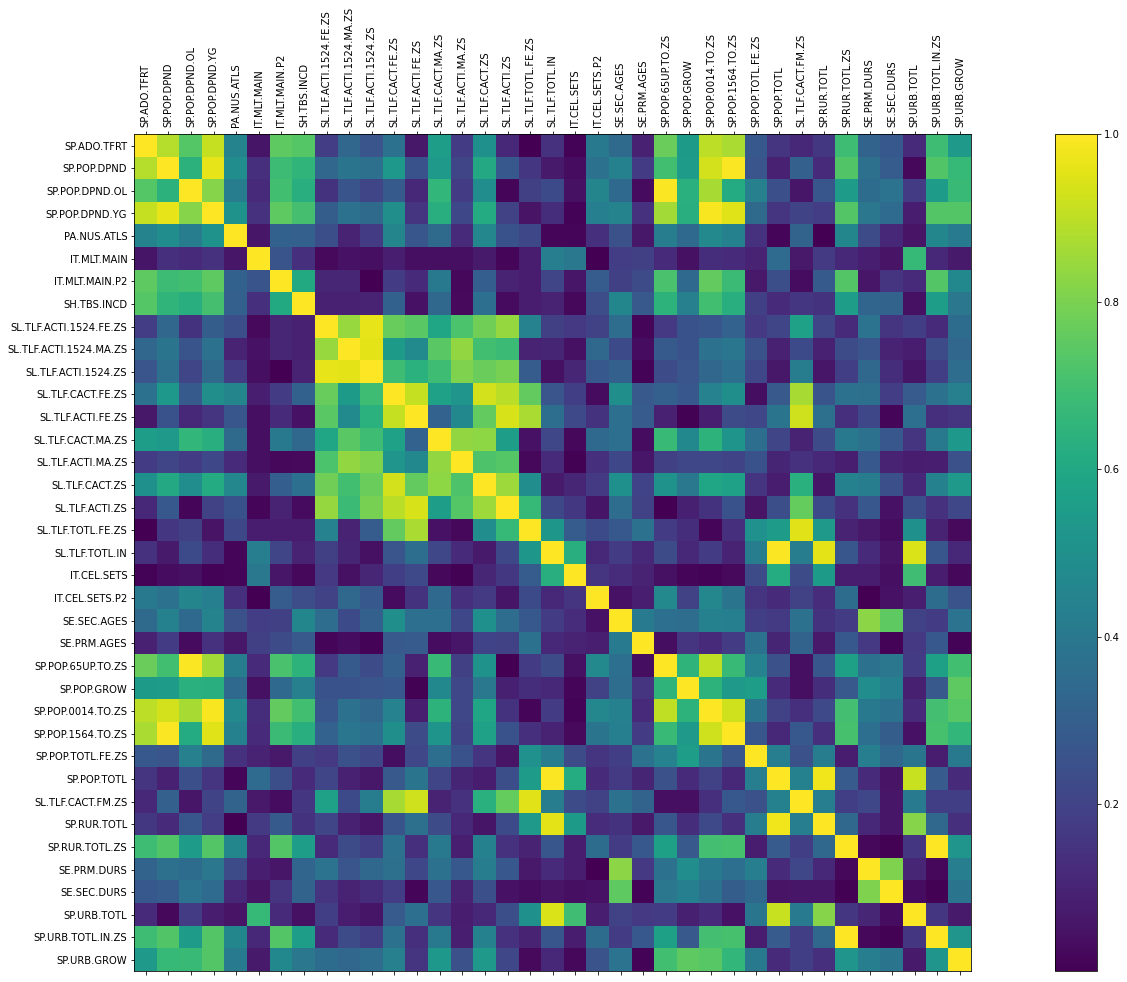

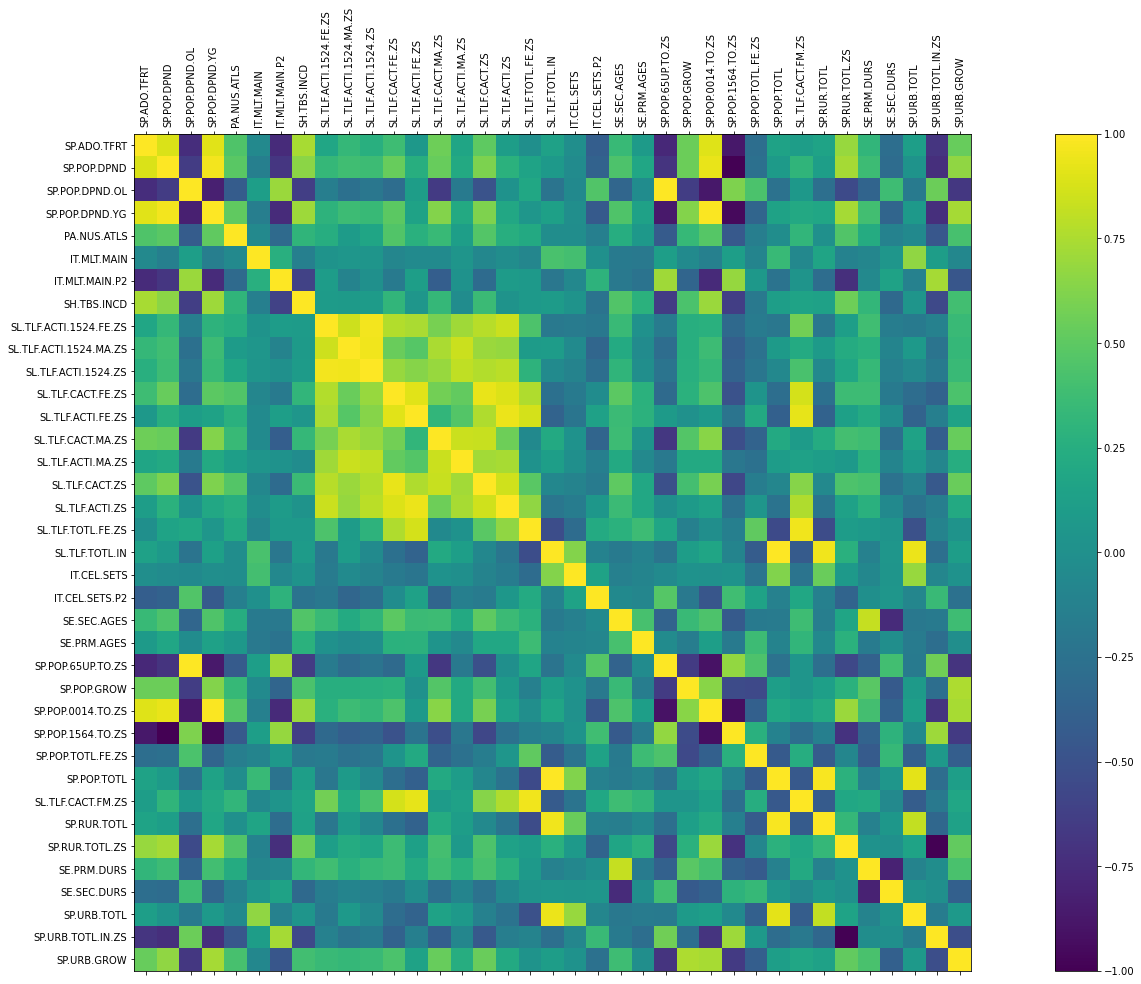

In [18]:
corrmat(abs = True);
corrmat(abs = False);

The first heatmap describes the degree of absolute correlation between all combinations of variable pairs. i.e the magnitude of linear relationship beteen the two, but not the direction. The second correlation heatmap gives the magnitude and direction of linear relationship between all combinations variable pairs.

## PCA

PCA is a type of linear transformation on a given data set that has values for a certain number of variables (coordinates) for a certain amount of spaces. This linear transformation fits this dataset to a new coordinate system in such a way that the most significant variance is found on the first coordinate, and each subsequent coordinate is orthogonal to the last and has a lesser variance. 

Our data has so many variables and we want to remove the least important variables from this data. By using PCA, we project our 3 dimensional data into a 2 dimensional data and plot the the PCA components. The features that have the highest scores and loadings in each PCA component, are chosen has our data of interest. 

It is worth nothing that, we used data from 1990 to 2015 to find our PCA components and hence our features of interest. Also, when we used all the data set from 1960 to 2015, the most important features in each PCA change but it is difficult to read all the values because of the volume of the data. One feature which remained important however in both scenarios was 'SL.TLF.CACT.ZS'('Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)'. We decided to use this feature for our time-series analysis.

In [19]:
# Getting 10 PCA components
pcamodel = PCA(n_components=10)
pca = pcamodel.fit_transform(data_scaled)

In [20]:
print(f"{n_years} years are under consideration")

25 years are under consideration


In [21]:
summary_df = pd.DataFrame([pcamodel.explained_variance_ , pcamodel.explained_variance_ratio_]).transpose()
summary_df.columns = ["explained_variance","explained_variance_ratio"]
summary_df

,explained_variance,explained_variance_ratio
0,13.046160,0.352278
1,7.549224,0.203848
2,4.176577,0.112778
3,2.954278,0.079773
4,1.993378,0.053826
5,1.308509,0.035333
6,1.006588,0.027180
7,0.774176,0.020905
8,0.692809,0.018708
9,0.624541,0.016864


#### Explained variance and cummulative variance plot

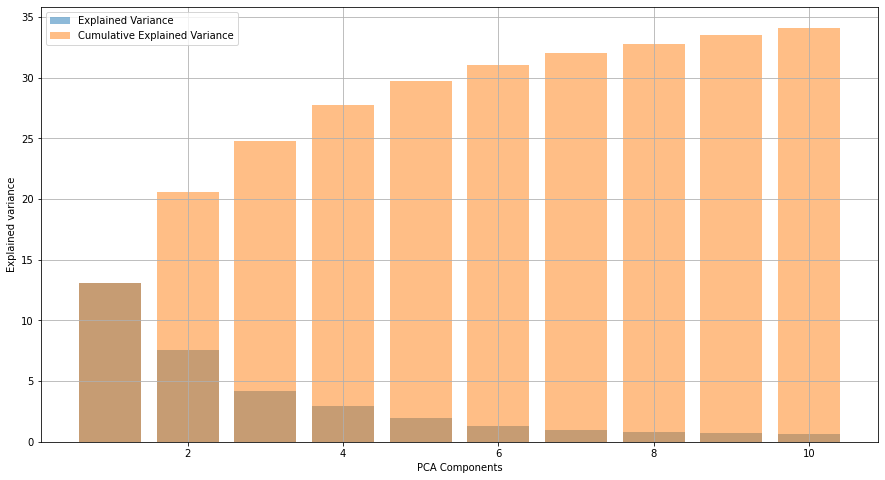

In [22]:
plt.figure(figsize=(15,8))

plt.bar(range(1,len(pcamodel.explained_variance_ )+1),
        pcamodel.explained_variance_,
        label="Explained Variance", alpha = 0.5)
plt.ylabel('Explained variance')
plt.xlabel('PCA Components')
plt.bar(range(1,len(pcamodel.explained_variance_ )+1),
         np.cumsum(pcamodel.explained_variance_),
         label="Cumulative Explained Variance", alpha = 0.5)
plt.legend(loc='upper left')
plt.grid()

#### Explained variance ratio plot

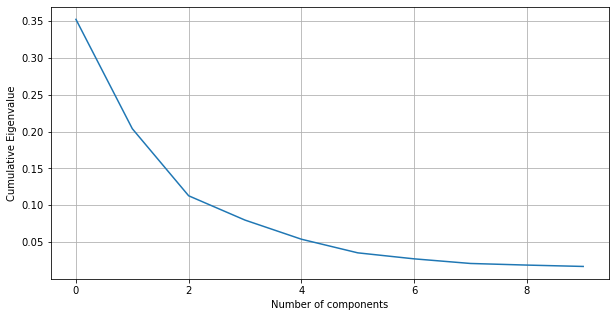

In [23]:
plt.figure(figsize=(10,5))
plt.plot(pcamodel.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Cumulative Eigenvalue')
plt.grid()
plt.show()

####  Scree plot

The scree plot is a plot of the number of PCA components against the eigenvalues.We chose the first 6 PCA components for further analysis of for our features of interest. These PCA components have an eigenvalue greater than 1(rule of thumb).

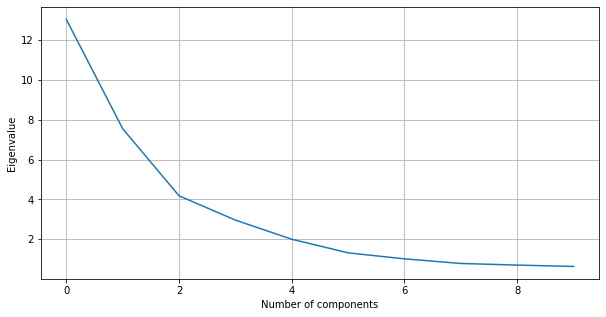

In [24]:
plt.figure(figsize=(10,5))
plt.axis
plt.plot(pcamodel.explained_variance_)
plt.xlabel('Number of components',)
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [25]:
pcamodel.explained_variance_

array([13.04616037,  7.54922392,  4.17657712,  2.95427795,  1.99337796,
        1.30850867,  1.00658751,  0.77417555,  0.69280901,  0.6245406 ])

## PCA plots

This section has scatter plots of all our the 6 PCA components. Each PCA component is plotted against the other, for the purpose of visualisation. 

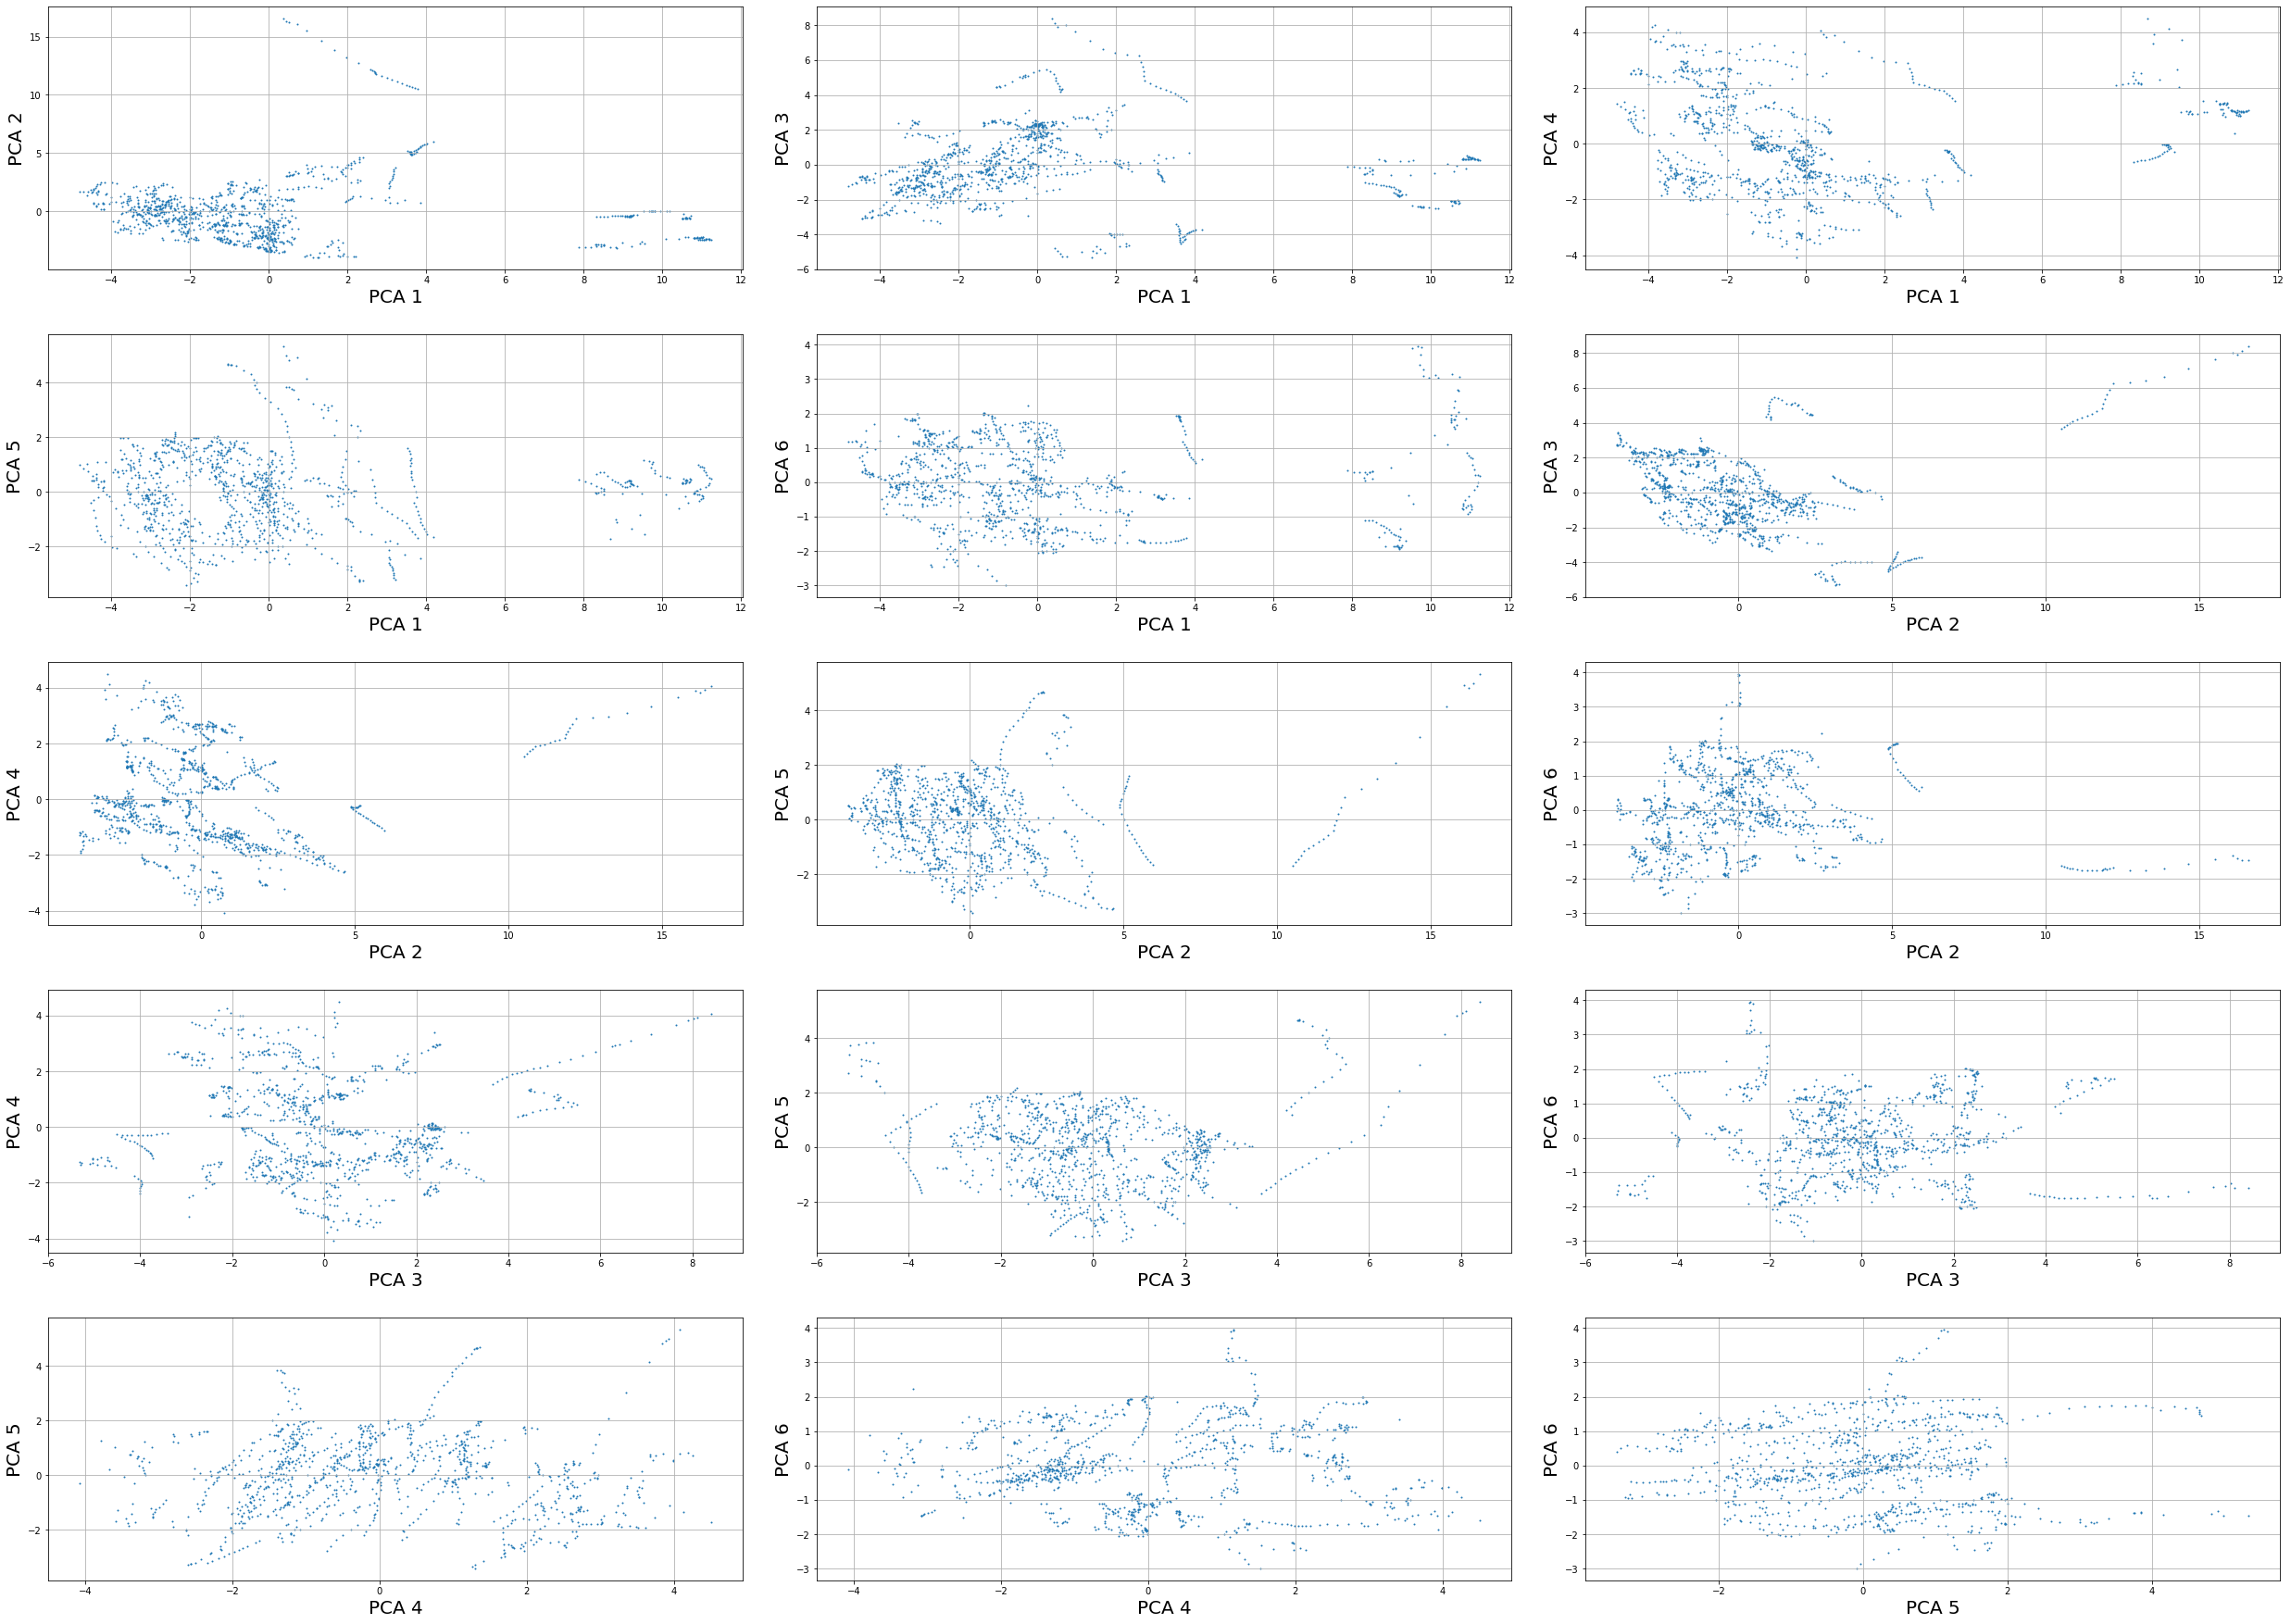

In [26]:
z = 0
n=0
fig, axs = plt.subplots(5, 3, figsize = (35,25))
for i in range(0,6):
  for j in range(i+1,6):
    axs[n,z].scatter(pca[:, i], pca[:, j], s = 1)
    axs[n,z].set_xlabel(f"PCA {i+1}", fontsize = 20)
    axs[n,z].set_ylabel(f"PCA {j+1}", fontsize = 20)
    axs[n,z].grid()
    z += 1
    if z % 3 == 0:
      n += 1
      z = 0
fig.tight_layout(pad=3.0)

#### Effect of variables on each component

To analyze the effect of each variable on our PCA components, we used a heatmap to help with the analysis. This is because, it is difficult to read the most important variables/features using the biplots. The number of features is high, and we would have to plot 15 different plots to able to read these variables.

Each color on the heatmap represents the loading value (-0.4 to 0.6) of each variable. The top 4 most important variables in the 6 PCA components are indicated below.

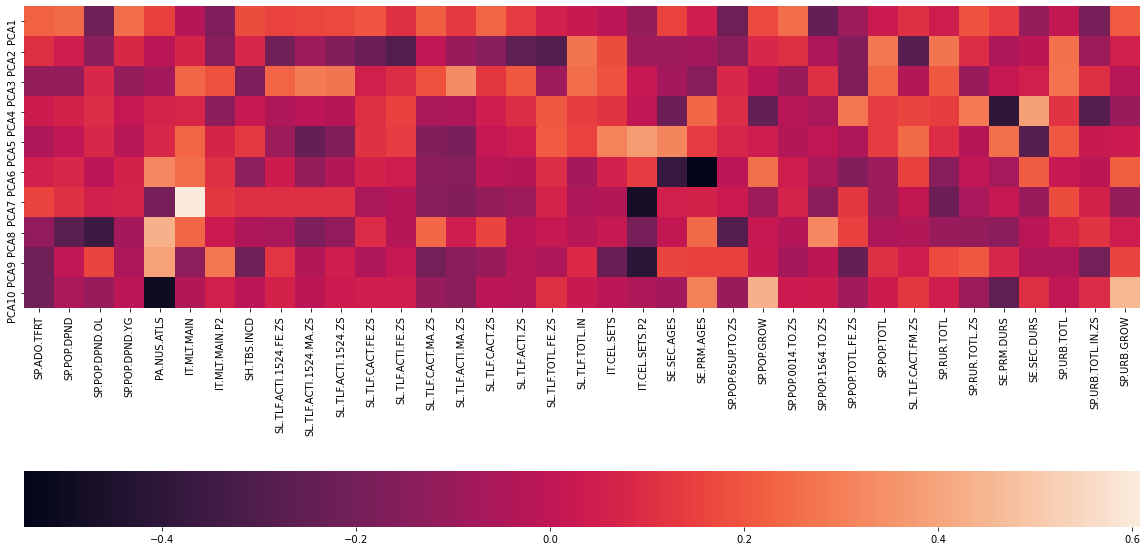

In [27]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(pcamodel.components_,
                 yticklabels=[ "PCA"+str(data_scaled) for data_scaled in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(data_scaled.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

<prev>
    Considering the first 6 PCA's, the top 4 variables with the most influence in these components are:
    
    PCA 1
    -SP.POP.0014.TO.ZS
    -SP.POP.DPND.YG
    -SP.POP.DPND
    -SP.ADO.TFRT
    
    PCA 2
    -SL.TLF.TOTL.IN
    -SP.POP.TOTL
    -SP.RUR.TOTL
    -SP.URB.TOTL
    
    PCA 3
    -SL.TLF.ACTI.MA.ZS
    -LTLF,ACTI.1524.ZS
    -SL.TLF.CACT.FE.ZS
    -SP.URB.TOTL
    
    PCA 4
    -SE.SEC.DURS
    -SP.RUR.TOTL.ZS
    -SP.POP.TOTL.FE.ZS
    -SE.PRM.AGES
    
    PCA 5
    -IT.CEL.SETS.P2
    -SE.SEC.AGES
    -IT.CEL.SETS.P2
    -SE.PRM.DURS
    
    PCA 6
    -PA.NUS.ATLS
    -SP.POP.GROW
    -SE.SEC.DURS
    -SP.URB.GROW
    
<prev/>

## Biplot

The biplot is to confirm the variables we selected for PCA 1 and PCA 2. Similar plots could also be made for each of the 6 PCAS

In [28]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(15,15))
    plt.scatter(xs * scalex,ys * scaley,s=5)
    
    results = []
    
    for i in range(n):
        arrow_color = 'g'
       
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
        if abs(coeff[i,0]) > 0.2 and abs(coeff[i,1]) > 0:
            results.append(labels[i])
         
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color =  arrow_color,alpha = 0.5)

 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    return results

influential_attributes = []

[['SP.ADO.TFRT', 'SP.POP.DPND', 'SP.POP.DPND.OL', 'SP.POP.DPND.YG', 'SL.TLF.CACT.MA.ZS', 'SL.TLF.CACT.ZS', 'SP.POP.65UP.TO.ZS', 'SP.POP.0014.TO.ZS', 'SP.POP.1564.TO.ZS', 'SP.URB.GROW']]


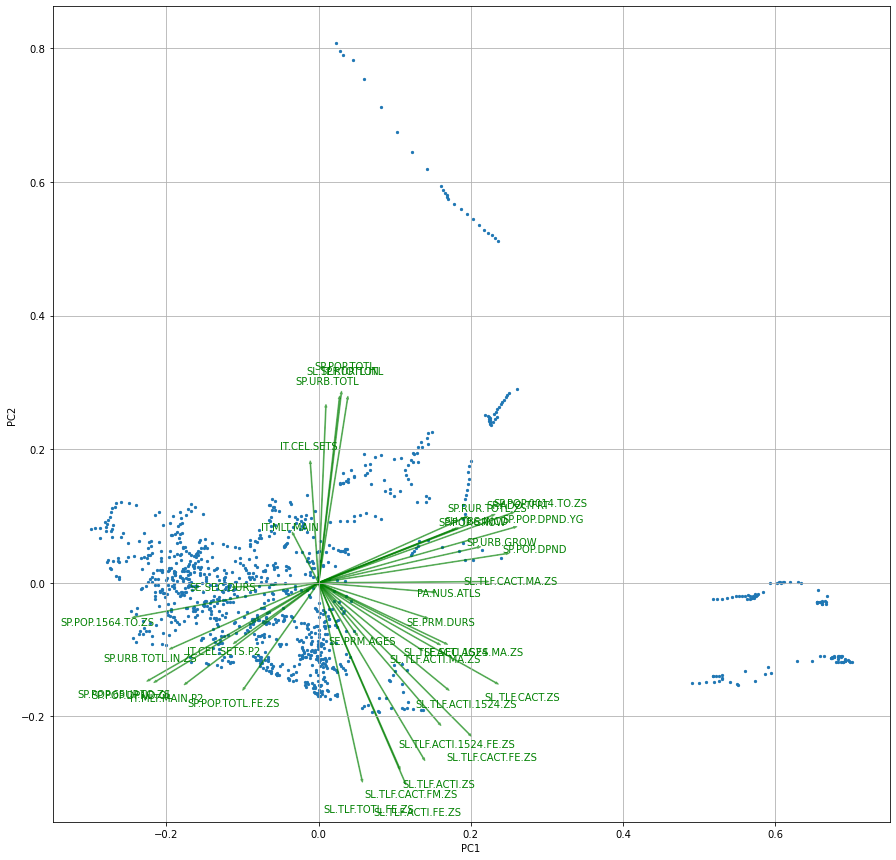

In [29]:
temp = myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(data_scaled.columns))
influential_attributes.append(temp)
print(influential_attributes)

Reference: https://www.datacamp.com/community/tutorials/pca-analysis-r?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034343&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1010917&gclid=CjwKCAiAn7L-BRBbEiwAl9UtkBQqYq82Kg5U1-ucgfKeKxLWAla5DR8Lz3UzTbgvjb-jkmXoivPx_hoCSLEQAvD_BwE

In [30]:
#### Get full names of the indicators we are are interested in.

indicators_df[indicators_df['IndicatorCode'].isin(influential_attributes[0])]["IndicatorName"].unique()

array(['Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old (% of working-age population)',
       'Age dependency ratio, young (% of working-age population)',
       'Population ages 65 and above (% of total)',
       'Population, ages 0-14 (% of total)',
       'Population, ages 15-64 (% of total)',
       'Urban population growth (annual %)',
       'Labor force participation rate, male (% of male population ages 15+) (modeled ILO estimate)',
       'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)'],
      dtype=object)

### Hierarchical Clustering

In this section, hierarchical clustering is used to cluster the features of our data.  Different methods (average, ward, single and complete) were tested to see if we can get better and clear clusters of our features.

However, due to the number of features in the data set, we could not read our clusters clearly as it can be shown below. 

Hierarchical clustering was rather performed on the countries which showed some clear and readable clusters.

In [31]:
X = data_final.iloc[:,:].values

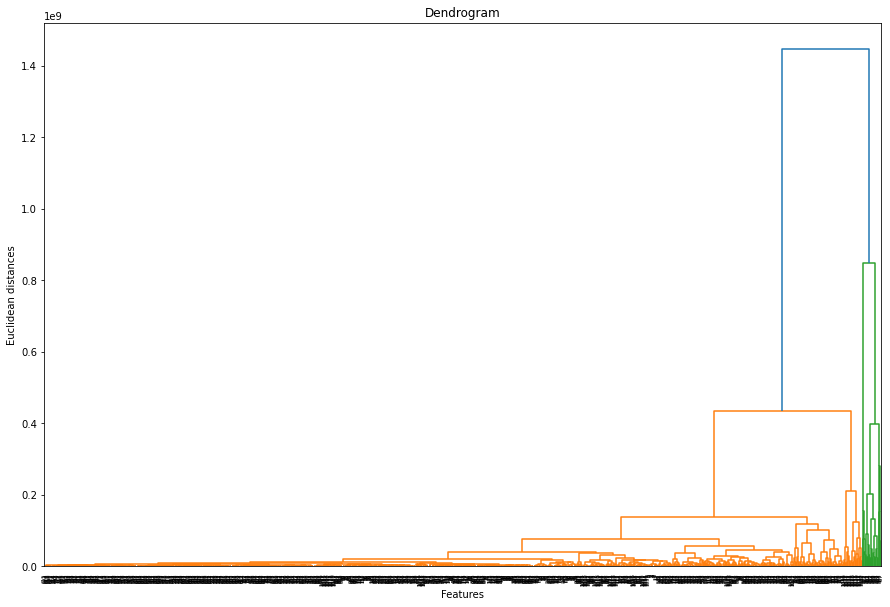

In [32]:
plt.figure(figsize=(15,10))
dendrogram = sch.dendrogram(sch.linkage(X, method  = "average"))
plt.title('Dendrogram')
plt.xlabel('Features')
plt.ylabel('Euclidean distances')
plt.show()

In [33]:
hc = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage ='average') ###use; average, complete and singular methods
y_hc = hc.fit_predict(X)

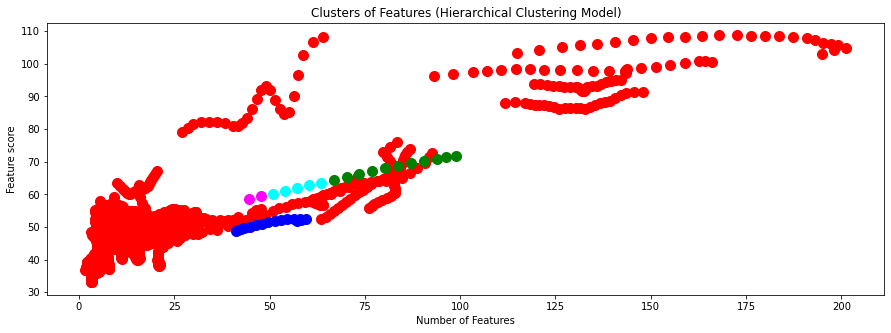

In [34]:
plt.figure(figsize=(15,5))
plt.scatter(X[y_hc==0, 0], X[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_hc==1, 0], X[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_hc==2, 0], X[y_hc==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y_hc==3, 0], X[y_hc==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y_hc==4, 0], X[y_hc==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.title('Clusters of Features (Hierarchical Clustering Model)')
plt.xlabel('Number of Features')
plt.ylabel('Feature score')
plt.show()

Reference : https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318

### COUNTRY CLUSTERING

Below, different clustering algorithms are used to determine the degree of similarity between countries to ultimately cluster them into groups. To distill the degree of similarity between countries to a simple scalar metric, Dynamic Time Warping was used. After dynamic time warping, hierarchical clustering, k-medoids clustering and multidimensional scaling paired with k-means were investigated.

In order to achieve this, a larger set of indicators was required. Thus, it was necessary to reduce the threshold for indicator disqualification. The most important from the new set was then quantified and filtered out using PCA.

In [ ]:
processed_attributes , n_years= create_df(0.3, 0.85, 1990,2015)
country_list = get_country_list(processed_attributes)
imputed_array = impute_a(processed_attributes,range(0,len(country_list)))
data_final = pd.concat(imputed_array)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_final)
data_scaled = pd.DataFrame(data_scaled, columns=data_final.columns)
pcamodel = PCA(n_components=10)
pca = pcamodel.fit_transform(data_scaled)

Adding ARG 0.4833035714285714
Adding AUS 0.4632440476190476
Adding AUT 0.4811607142857143
Adding BEL 0.463125
Adding CAN 0.4529761904761904
Adding CZE 0.49872023809523813
Adding DNK 0.4911011904761905
Adding ECU 0.6455654761904762
Adding EST 0.45895833333333336
Adding FIN 0.4933630952380952
Adding FRA 0.48684523809523805
Adding DEU 0.4795238095238096
Adding GRC 0.47627976190476196
Adding HKG 0.38592261904761904
Adding HUN 0.5111011904761904
Adding ISL 0.4392559523809524
Adding IND 0.6361309523809524
Adding IRL 0.47901785714285716
Adding ISR 0.43875
Adding ITA 0.4899404761904762
Adding KOR 0.5043154761904762
Adding LVA 0.45116071428571425
Adding LTU 0.4419047619047619
Adding LUX 0.41770833333333335
Adding MEX 0.6895238095238095
Adding NLD 0.4805952380952381
Adding NZL 0.43675595238095233
Adding NGA 0.5913690476190476
Adding NOR 0.47413690476190473
Adding POL 0.4951488095238096
Adding PRT 0.4770833333333333


MAP PC's to their variables with their respective loadings.


In [ ]:
comps = pd.DataFrame(pcamodel.components_, columns = data_final.columns)
n_pcs= pcamodel.n_components_  # get number of component

DISPLAY PC's, INDICATORS AND THEIR RESPECTIVE LOADINGS

In [ ]:
comps.index = [f"PCA {i}" for i in range(1,11)]
comps

In [ ]:

def makena(value):  
  """
  Returns NaN if value is True and np.nan if value is False
  """
  if value == False:
    return(np.nan)
  else:
    return True

def find_influential(n_pc,threshold):
  """
  Uses a threshold to filter the components to select from each PC.
  Only uses the first "n_pc" PC's.
  """
  comp_bool = (abs(comps)>threshold)[0:n_pc]
  comp_bool = comp_bool.applymap(makena)
  comp_bool.dropna(thresh=2,axis=1,inplace=True)
  influential = comp_bool.columns
  print(f"{len(influential)} indicators selected")
  return (influential)
influential = find_influential(2,0.055)


NORMALIZATION, SCALING AND GROUPING BY COUNTRY

In [ ]:
#Determine the number of countries were working with
n_countries = len(imputed_array)

In [ ]:
#Filter selected features from scaled dataframe and assign to variable
clustering_df_pre = data_scaled[influential]
#Create list where each index is the dataframe containing the multivariate time 
#series for each country
clustering_df = []
for i in range(n_countries):
  clustering_df.append(clustering_df_pre[(n_years)*i: (n_years)*(i+1)])

In [ ]:
#VECTORIZED IMPLEMENTATION OF THE DTW ALGORITHM. 
#c1 = country 1, c2 = country2
#1. PERFORM DTW between indicatorA (c1) and indicatorA(c2)
#to compute total distance between indicators (scalar (x_n))
#2. APPLY over time all time series between country1 and country2 to 
# to obtain vector v(x_1,x_2,x_3)
#3. FIND mean of resultant vector M_c1_c2 (this is the distance between c1 & c2)
#4. Repeat for all combinations of c_i & c_j where i != j

#BETWEEN THE DISSIMILARITY BETWEEN THE SET OF TIME SERIES FOR ONE COUNTRY AND THE SET 
#OF TIME SERIES FOR ANOTHER. IT MAY BE USEFUL TO WRITE THE PSEUDOCODE IN LATEX
#FOR EASY COMPREHENSION.
def total_dtw(x,y):
  """
  Returns euclidean distances between two time series' of the same type coming
  from two different countries'.
  """
  return (list(map(lambda a, b : fastdtw(a, b, dist=euclidean)[0],x,y)))
def get_distances(i, offset, df_table):
  """
  Performs dynamic time warping between all corresponding time series' between
  two countries (maps total_dtw function over all indicators) and returns the 
  mean of the computed distance vector.
  """
  ts1 = np.array(df_table[i][::offset].transpose())
  if offset >1:
      return list(map(lambda b: np.mean(total_dtw(ts1,np.array(df_table[b][::offset].transpose()))), range(i+1,len(clustering_df))))
  else:
      return list(map(lambda b: np.mean(total_dtw(ts1,np.array(df_table[b][::offset].transpose()))), range(i+1,len(clustering_df))))

#maps the get_distance function over all countries
res = list(map(lambda x: get_distances(x, 10, clustering_df), range(0,len(clustering_df))))

Reference: https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd

In [ ]:
#Creates an empty numpy array to contain distance matrix
zero_mat = np.zeros([len(res),len(res)])
for i in range(len(zero_mat)):
  zero_mat[i,i+1:] = res[i]

VISUALIZE DISTANCE MATRIX

In [ ]:

dist_mat = np.array(zero_mat) + np.array(zero_mat).transpose()
dist_mat = pd.DataFrame(dist_mat/np.max(dist_mat))
np.mean(np.max(dist_mat))
dist_mat.columns = country_list
dist_mat.index = country_list

In [ ]:
from sklearn.cluster import AgglomerativeClustering
def cluster(dist_mat, thresh):
  """
  Performs agglomerative clustering the given distance matrix and returns 
  a dictionary of predictions.
  """
  cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', distance_threshold=thresh)
  prediction = cluster.fit_predict(dist_mat)
  return (prediction)
names = country_list
def get_c_dict(dist_mat, prediction, names):
  """
  Returns dictionary with cluster index as the key and list of countries as the 
  value
  """
  c_dict = {}
  names = dist_mat.columns
  for i in range(dist_mat.shape[0]):
    try:
      c_dict[prediction[i]].append(names[i])
    except:
      c_dict.update({prediction[i]:[names[i]]})
  return c_dict
c_pred = cluster(dist_mat, 0.95)
c_dict=get_c_dict(dist_mat,c_pred, names)

In [ ]:
c_dict

Try multiple linkages of agglomerative heirarchical clustering.

In [ ]:
#CREATE DICTIONARY OF KEY = COUNTRIES AND THEIR VALUE = CLUSTER 
df_a = pd.DataFrame(pd.Series(c_dict))
df_a.reset_index(inplace = True)
names = []
n_clusters = 6
for i in range(n_clusters):
  names.append(list(df_a[df_a[0] == i]['index'].values))
def check_symmetric(dist_mat, rtol=1e-05, atol=1e-08):
  """
  Determines whether the supplied distance matrix is symmetrical and returns 
  a boolean of the result
  """
  return np.allclose(dist_mat, dist_mat.T, rtol=rtol, atol=atol)
check_symmetric(dist_mat)

PLOT DENDOGRAM USING DIFFERENT METHODS


In [ ]:
methods = ["average", "weighted", "median", "centroid", "single", "ward"]
dists = squareform(dist_mat)
for method in methods:
  linkage_matrix = linkage(dists, method)
  plt.figure(figsize = (20,5))
  dendrogram = sch.dendrogram(linkage_matrix, labels = country_list)
  plt.title(f"{method.capitalize()} Method Dendogram")
  plt.show()  

PERFORM K-MEDOIDS CLUSTERING ON SUPPLIED DISTANCE MATRIX

In [ ]:
initial_medoids = [1,2,3,4,5,6]
kmedoids_instance = kmedoids(np.array(dist_mat),initial_medoids,data_type='distance_matrix')
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
c_list = list(map(lambda x: list(np.array(country_list)[np.array(x)]),clusters))
c_dict = dict(zip(range(0,6),c_list))
c_dict

Reference: https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca

PERFORM MULTIDIMENSIONAL SCALING AND K-MEANS CLASSIFICATION

In [ ]:
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
mds_fit = mds_model.fit(np.array(dist_mat))  
mds_coords = mds_model.fit_transform(np.array(dist_mat))
plt.figure( figsize = (15,10))
plt.scatter(mds_coords[:,0],mds_coords[:,1])
plt.xlabel("Cardinal x - position")
plt.ylabel("Cardinal y - position")
plt.title("Cardinal Locations of Points after MDS")
for j in range(mds_coords.shape[0]):
  plt.annotate(country_list[j], (mds_coords[j,0],mds_coords[j,1]), fontsize = 10)
plt.grid()

Reference: https://www.statisticshowto.com/multidimensional-scaling/

USE K-MEANS CLUSTERING

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 6)
prediction = model.fit(mds_coords)
prediction = prediction.labels_
c_dict = {}
names = country_list
get_c_dict(dist_mat,prediction, names)

Reference: https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a

IMPORT DATA FOR TIME SERIES FORECASTING

In [ ]:
processed_attributes , n_years= create_df(0.3, 0.8, 1960,2015)
country_list = get_country_list(processed_attributes)
imputed_array = impute_a(processed_attributes,range(0,len(country_list)))
data_final = pd.concat(imputed_array)
data_final.index = processed_attributes.index

ARIMA (PARAMETER GUESSING)

USING VECTOR AUTOREGRESSION

In [ ]:
ind_codes = ["SP.POP.1564.TO.ZS","EN.ATM.CO2E.SF.ZS","SP.DYN.TFRT.IN","NE.CON.TETC.ZS"]
data = data_final.loc["USA"][ind_codes]

n_years = data.shape[0]

#creating the train and validation set
train = data[:int(0.7*(len(data)))]
test = data[int(0.7*(len(data))):]
print(test.index[0])
#fit the model
model = VAR(endog=train)
model.select_order
try:
    model_fit = model.fit(maxlags = 30, trend = 'ct')
except:
    pass
model_fit = model.fit(maxlags = 30, trend = 'ct')
# make prediction on validation
prediction = model_fit.forecast(model_fit.y,steps=len(test))
col = ["#000000","#FF00FF","#FF0000","#00FF00"]
plt.figure(figsize = (15,10))
for i in range(0,4):
  plt.scatter(x = test.index, y = prediction[:,i], c = col[i], marker = ".", label = ind_codes[i]);
  plt.scatter(x = test.index, y = test.iloc[:,i], c = col[i], marker = "_");
plt.xlabel("Year")
plt.ylabel("Indicator Value")
plt.title("Time Series using VAR")
plt.legend();
plt.grid();
plt.show()

Reference: https://towardsdatascience.com/vector-autoregressive-for-forecasting-time-series-a60e6f168c70

QUANTIFY PERFORMANCE

In [ ]:
pred_df = pd.DataFrame(prediction)
test_df = pd.DataFrame(test).reset_index().drop('index',1)
pred_df.columns = test_df.columns
mape = (np.abs(pred_df - test_df)/test_df).mean()*100
mse = ((pred_df - test_df)**2).mean()
perf_dict = dict(zip(["SP.POP.1564.TO.ZS","EN.ATM.CO2E.SF.ZS","SP.DYN.TFRT.IN","NE.CON.TETC.ZS"],list(zip(mse,mape))))
perf_df = pd.DataFrame(perf_dict).transpose()
perf_df.columns = ['MSE',"MAPE"]
perf_df

### Support Vector Regressor(SVR)

In this problem, we have to train a SVR model with our chosen variable and country to understand the correlation between the time steps and the feature/variable and be able to predict the value of these features based on the years of reported data.For a non-linear regression, the kernel function transforms the data to a higher dimension and performs the linear separation. We will use the rbf kernel.

Further optimization of the model is done to choose the best parameters of gamma, epsilon and c(penalty parameter), and then predicting the new features using the test data.

The accuracy method used is MAPE = 2.45 and MSE = 1.087 .

In [ ]:
data_final_country = data_final[np.in1d(data_final.index.get_level_values(0), ['USA'])]
data_usa = data_final_country['SP.POP.1564.TO.ZS']

In [ ]:
year_usa = list(map(lambda x: x[1], data_usa.index))
feature_usa = data_usa.values

### Transform data to matrix and 1-dimensional data for SVR

X = np.asmatrix(year_usa).reshape(-1,1)
Y = np.asmatrix(feature_usa).reshape(-1,1)
X_train = X[0:44]
X_test = X[45:]
y_train = Y[0:44]
y_test = Y[45:]


##### Fit SVR on train data with random c, epsilon and gamma

In [ ]:
svr_model = SVR(kernel= 'rbf', C= 1000, epsilon = 0.05, gamma= 0.001)
svr_model.fit(X_train,y_train)
y_pred = svr_model.predict(X_test)

### SVR Optimization

In [ ]:
### Grid search with cross-validation to determine best optimization parameters.

gsc = GridSearchCV(estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv = 5, scoring='neg_mean_squared_error', verbose=0)

grid_result = gsc.fit(X, Y)
best_params = grid_result.best_params_


In [ ]:
#### Using best parameters to predict the features

best_svr = SVR(kernel = 'rbf', C = best_params["C"], epsilon = best_params["epsilon"], gamma = best_params["gamma"],
                   coef0 = 0.1, shrinking = True,
                   tol = 0.001, cache_size = 200, verbose = False, max_iter = -1)
best_svr.fit(X_train,y_train)
y_pred = best_svr.predict(X_test)


In [ ]:
plt.figure(figsize = (15,5))
plt.plot(X, Y, color= 'blue', label= 'Data')
plt.plot(X_test,y_pred, color= 'red', label= 'RBF model') 
plt.xlabel('Years')
plt.ylabel('Feature: SP.POP.1564.TO.ZS')
plt.title('Population ages 15-64 (% of total population)-USA')
plt.grid()
plt.legend()
plt.show()

#### Errors for SVR

In [ ]:
def get(true_values, predicted_values, error_method='mape'): # function to calculate the error for MAPE and MSE
    error = 0

    if error_method == 'mape':
        # calculate the mean absolute percentage error
        error = np.mean(abs((true_values - predicted_values) / true_values)) * 100
        error = round(error, 3)

    if error_method == 'mse':
        
        # calculate the mean squared error
        error = round(math.sqrt(mean_squared_error(true_values, predicted_values)), 3)

    return error

#### MAPE

In [ ]:
get(y_test,y_pred, error_method = 'mape')

#### MSE

In [ ]:
get(y_test,y_pred, error_method = 'mse')

## Time series forcast using random forest

In this section, we are using the Random Forest regressor for time series forecasting. We will be using a time series with single indicator, the indicator is from the country USA and the indicator name is Population ages 15-64 (% of total population).




In [ ]:
def timeseries_supervised(value, input_steps=1, out_steps=1, dropnan=True):
    '''
     creates  a supervised learning dataset by using previous time steps as input variables
     and use the next time step as the output variable.
     
     returns a two dimensional array
    '''
    
    df = DataFrame(value)
    columns = [] 
    #put input sequence to a list
    for i in range(input_steps, 0, -1):
        columns.append(df.shift(i))  
    # put forcast sequence to alist
    for i in range(0, out_steps):
        columns.append(df.shift(-i))    
    concatnate = concat(columns, axis=1)
    # drop rows with NaN values
    if dropnan:
        concatnate.dropna(inplace=True)
    return concatnate.values
 

def split_train_test(data, test_num):
    '''
    splits and returns dataset into train/test sets
    '''
    return data[:-test_num, :], data[-test_num:, :]
 

def random_forest_forecast(train, testX):
    '''
     one step prediction by fiting a random forest model 
     returns predicted value
    '''
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]
 

def walk_forward_validation(data, n_test):
    '''    
      Splits the dataset into train and test, in order to make a one-step forcast, we evaluate
      the model by training on the training dataset and predicting the first step in the test dataset.
      We can then add the real observation from the test set to the training dataset,
      refit the model, then have the model predict the second step in the test dataset.
     
      returns  mae,mape,mse, actual value, predictions value
    '''
    predictions = list()
    # split dataset
    train, test = split_train_test(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('-> actual=%.1f, -> predicted=%.1f' % (testy, yhat))
        # estimate prediction error
    mape=np.mean(np.abs((test[:, -1] - predictions) / test[:, -1])) * 100
    mse=mean_squared_error(test[:, -1], predictions)
    mae = mean_absolute_error(test[:, -1], predictions)
    return mae,mape,mse, test[:, -1], predictions
    
 
# load the dataset
data_final.index = processed_attributes.index
data_USA=data_final.loc['USA']
ts = pd.Series(data_USA['SP.POP.1564.TO.ZS'].values, index=data_USA.index)
df = pd.DataFrame({'time':ts.index, 'measure':ts.values})
df_time=df.set_index('time')
values = df_time.values

data = timeseries_supervised(values, 10,1)

# evaluate
mae,mape,mse, y, yhat = walk_forward_validation(data, 20)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
print('MSE: %.3f' % mse)
# plot expected vs predicted
pyplot.plot(y, label=' Actual_values')
pyplot.plot(yhat, label='Predicted_values')
pyplot.ylabel('Actual/predicted values')
pyplot.legend()
pyplot.show()

Reference: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

# ARIMA forecasting

In [ ]:
indicator_code = 'SP.POP.1564.TO.ZS' # 'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)'

### Selecting data

In [ ]:
# put index to data_final if it does not exist
data_final.index = processed_attributes.index

In [ ]:
train_ratio = 0.8

data_final_country = data_final[np.in1d(data_final.index.get_level_values(0), ['USA'])][[indicator_code]].reset_index(level=0,drop=True)

train_cutoff = int(len(data_final_country[[indicator_code]]) * train_ratio)

data_final_country_train = data_final_country[[indicator_code]][:train_cutoff]
data_final_country_test = data_final_country[[indicator_code]][train_cutoff:]

### Testing stationarity

#### Types of Stationarity

Strict Stationary: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.

Trend Stationary: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.

Difference Stationary: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.



### Augmented Dickey-Fuller test (ADF)

In [ ]:
ts = data_final_country

result = adfuller(ts)
print('ADF statistic : %f' % result[0])
# the 0 element is the test statistics, 
#the more negative it is the more likely that the data is stationary

print('p-Value: %f'%result[1])

# the 1 element is the p_value 
# if p-value is small, reject the H0. Reject non-stationary
print('Critical values:')
for key, value in result [4].items():
    print('\t%s: %.3f' % (key, value))
# the 4th element is the critical test statistics,
# our test statistic needs to be below the critical value to get less than the p-value

if result[0] < result[4]['5%']:
    print ('Reject Hypothesis 0 - Time series is stationary')
else :
    print ('Failed to reject the null hypothesis - Time series is Non-Stationary')

References:

Dickey-Fuller test for Time Series Stationarity using Python: https://www.youtube.com/watch?v=warCSvy1DMk&ab_channel=BhaveshBhatt

Python Tutorial: Making time series stationary: https://www.youtube.com/watch?v=bP1fbXd_XSk&ab_channel=DataCamp

### Testing trend stationarity

In [ ]:
# It’s better to apply both tests (ADF and KPSS) to be sure that the series is truly stationary.

# kpss test function
def kpss_test(ts):
    """
    Returns KPSS test results: test statistic, p-value, and the critical value at 1%, 2.5%, 5%, and 10% confidence intervals
    """
    kpsstest = kpss(ts, regression='c',nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
     
    return kpss_output
    
kpss = kpss_test(ts)
print(kpss)

# Test for stationarity: If the test statistic is greater than the critical value, 
# we reject the null hypothesis (series is not trend stationary).
if kpss['Test Statistic'] < kpss['Critical Value (5%)']:
    print ('Failed to reject the null hypothesis - Time series is Non-(trend) Stationary') 
else :
    print ('Reject Hypothesis 0 - Time series is (trend) stationary')

#### Checking which stationarity type is our time series from comparing both tests outcomes

Case 1: Both tests conclude that the series is not stationary -> series is not stationary

Case 2: Both tests conclude that the series is stationary -> series is stationary

Case 3: KPSS = stationary and ADF = not stationary -> trend stationary, remove the trend to make series strict station ary

Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary


Reference :

A Gentle Introduction to Handling a Non-Stationary Time Series in Python: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/ 

In [ ]:
# Case 1
if kpss['Test Statistic'] < kpss['Critical Value (5%)'] and result[0] > result[4]['5%']:
    print('The series is not stationary')

# Case 2
if kpss['Test Statistic'] > kpss['Critical Value (5%)'] and result[0] < result[4]['5%']:
    print('The series is stationary')

# Case 3
if kpss['Test Statistic'] > kpss['Critical Value (5%)'] and result[0] > result[4]['5%']:
    print('the series is Trend stationary, remove the trend to make series strict stationary')
    
# Case 4
if kpss['Test Statistic'] < kpss['Critical Value (5%)'] and result[0] < result[4]['5%']:
    print('Use differencing to make series stationary')

### ARIMA parameters : p , d and q

<b>p:</b> The number of lag observations included in the model, also called the lag order.

<b>d:</b> The number of times that the raw observations are differenced, also called the degree of differencing.

<b>q:</b> The size of the moving average window, also called the order of moving average.



Reference:

Autoregressive Integrated Moving Average (ARIMA): https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp

### Searching for "d"

In [ ]:
# one way to make the ts stationary is to take the difference
# calculating diff up to the 3-rd level
data_final_country.loc[:,f'{indicator_code}_diff_1'] = data_final_country[[indicator_code]].diff() # first differenciation
data_final_country.loc[:,f'{indicator_code}_diff_2'] = data_final_country[[f'{indicator_code}_diff_1']].diff() # second differenciation
data_final_country.loc[:,f'{indicator_code}_diff_3'] = data_final_country[[f'{indicator_code}_diff_2']].diff() # 3rd differenciation

In [ ]:
diff_values_country_1 = data_final_country[f'{indicator_code}_diff_1'].values
diff_values_country_2 = data_final_country[f'{indicator_code}_diff_2'].values
diff_values_country_3 = data_final_country[f'{indicator_code}_diff_3'].values

# initial time-series
Y_0 = data_final_country[indicator_code].values

# dropping nan in diff-ed values
Y_1 = diff_values_country_1[~np.isnan(diff_values_country_1)]
Y_2 = diff_values_country_2[~np.isnan(diff_values_country_2)]
Y_3 = diff_values_country_3[~np.isnan(diff_values_country_3)]

# drop last value in diff-ed time-series to align with the next diff
ts_values_1 = Y_0[:-1]
ts_values_2 = Y_1[:-1]
ts_values_3 = Y_2[:-1]

# add a column of ones to time-series 
X_1 = sm.add_constant(ts_values_1)
X_2 = sm.add_constant(ts_values_2)
X_3 = sm.add_constant(ts_values_3)

# prepare OSL (Ordinary Least Squares) models
model_1 = sm.OLS(Y_1, X_1)
model_2 = sm.OLS(Y_2, X_2)
model_3 = sm.OLS(Y_3, X_3)

# fit OSL models
results_1 = model_1.fit()
results_2 = model_2.fit()
results_3 = model_3.fit()

In [ ]:
# 1-st diff model summary
print(results_1.summary())

In [ ]:
# 2-nd diff model summary
print(results_2.summary())

In [ ]:
# 3-rd diff model summary
print(results_3.summary())

In [ ]:
# if t-value is smaller than critical value une the number of the differenciation as the d value for ARIMA function
print(results_1.tvalues[1]) 
print(results_2.tvalues[1]) 
print(results_3.tvalues[1])

In [ ]:
# perfom augmented Dickey-Fuller unit root test on each time-series (initial and diffs)
adfuller_0 = adfuller(Y_0)
adfuller_1 = adfuller(Y_1)
adfuller_2 = adfuller(Y_2)
adfuller_3 = adfuller(Y_3)

# initial d-value
d_value = 0

def is_t_value_less_than_critical_value(adf):
    """
    Check if t-value is less than critical value at 5%
    """
    if adf[0] < adf[4]['5%']:
        return True
    else:
        return False

# iterate through all adfuller results
for adf in [adfuller_0, adfuller_1, adfuller_2, adfuller_3]:
    if is_t_value_less_than_critical_value(adf):
        break
    else:
        d_value += 1
    
print('d_value:', d_value)

### Finding p and q through ACF and PACF plots

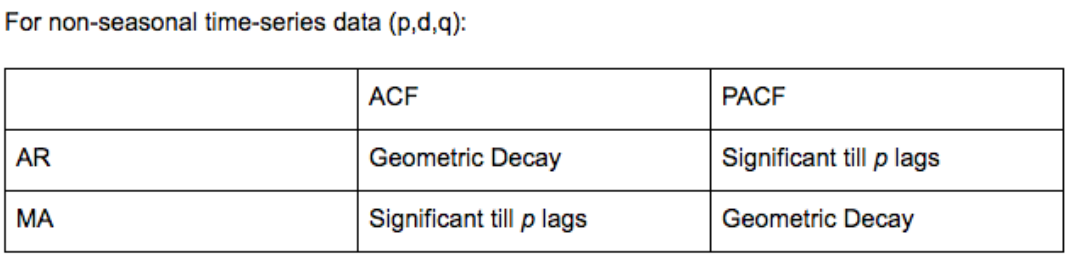

source: https://www.linkedin.com/pulse/reading-acf-pacf-plots-missing-manual-cheatsheet-saqib-ali?fbclid=IwAR2FbMaWr0uurgKgTiqSIDHgn4FhuP6h0Q7VM25tL0C5a1HD6A15plbkOF8

In [ ]:
# autocorrelation function plot
fig, ax = plt.subplots()
ax.set_xlabel("Lags")
ax.set_ylabel("Correlations")
plot_acf(Y_0, ax=ax)
plt.show()

In [ ]:
# partial autocorrelation function plot
fig, ax = plt.subplots()
ax.set_xlabel("Lags")
ax.set_ylabel("Correlations")
plot_pacf(Y_0, ax=ax, lags=10)
plt.show()

We can deduce from the ACF plot and the PACF plot the values of p and q. For example, if our ACF graph has a geometric decay and the PACF is significant till pth = 2nd lag, we have an AR with lag = 2 while the MA element is 0.

### ARIMA

In [ ]:
arima_model = ARIMA(data_final_country_train, (2,2,0)).fit()
print(arima_model.summary())

In [ ]:
resid = arima_model.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,4))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

plt.title('Residual distribution')

In [ ]:
# ACF
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlabel("Lags")
ax.set_ylabel("Correlations")
sm.graphics.tsa.plot_acf(arima_model.resid, lags=10, ax=ax)
plt.plot()

In [ ]:
# PACF
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlabel("Lags")
ax.set_ylabel("Correlations")
sm.graphics.tsa.plot_pacf(arima_model.resid, lags=10, ax=ax)
plt.plot()

In [ ]:
# residual and predicted values from the model
res_pred_df = pd.DataFrame(arima_model.resid, columns=['resid'])
res_pred_df['predict'] = arima_model.predict()

fig, ax = plt.subplots()
ax.set_xlabel('Years')
ax.set_ylabel('Residual values')
ax.set_title(f'Residual and predicted values ({indicator_code})')
res_pred_df[['resid', 'predict']].plot(figsize=(12, 4), ax=ax)
plt.plot()

In [ ]:
# original time-series and model forecast values
orig_fore_df = pd.DataFrame(data_final_country[[indicator_code]].values, columns=['value'], index=data_final_country.index)
orig_fore_df['forecast'] = None

orig_fore_df.loc[data_final_country_test.index.min():,('forecast')] = arima_model.forecast(data_final_country_test.shape[0])[0]

fig, ax = plt.subplots()
ax.set_xlabel('Years')
ax.set_ylabel('Values')
ax.set_title(f'Original time-series and forecast values ({indicator_code})')

orig_fore_df[['value', 'forecast']].plot(figsize=(12, 4), ax=ax)
plt.plot()

#### Error testing

In [ ]:
mse = np.mean(np.abs(np.array(res_pred_df[['resid']]) -  np.array(res_pred_df[['predict']])))
mape = np.mean(np.abs((np.array(res_pred_df[['resid']]) -  np.array(res_pred_df[['predict']]))/np.array(res_pred_df[['predict']])))
print('Test MSE: %.3f' % mse)
print('Test MAPE: %.3f' % mape)

# Conclusions

Variables that introduced the most variance into the data were 
- Adolescent fertility rate 
- Age dependency ratios (old, young, total)
- Population (ages 65+, 0-14, 15-64)
- Urban population growth
- Labor force participation rate, male
- Labor force participation rate, total

The different clustering methods resulted in similar outcomes. It could be observed from
the dendograms that countries clustered themselves into their respective geographical
locations with a few outliers. South Africa, for instance was never clustered with the
African countries. In two instances, it was clustered with Ecuador, Mexico and Argentina
and in the last instance, with a combination of Eastern European and Latin American countries.
Also, USA always occupied a cluster of its own.

After time series forecasting using different models, the following results were obtained:
ARIMA
- MSE: 0.049
- MAPE: 3.246

Random Forest
- MAE: 0.427
- MAPE: 0.680
- MSE: 0.219

Vector AutoRegression
- MSE 0.498047	
- MAPE 0.996106

Support Vector Regression
- MSE: 1.331
- MAPE:1.776

After performance, we concluded that the most accurate forecasting model was the Random Forest.